## Modify icedraft getz shelf (make similar to Grenoble version)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.interpolation import extend_into_mask
from nemo_python_git.constants import region_bounds, region_bathy_bounds

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

Modify file that goes into DOMAINcfg tool:

In [3]:
ds_bathy     = xr.open_dataset(f'{base_dir}bathymetry/bathy_meter_eORCA025_BedMachine3_IBCSO_AIS.nc')
# ds_bathy_new = xr.open_dataset(f'{base_dir}bathymetry/bathy_meter_eORCA025_BedMachine3_IBCSO_AIS_deep_getz.nc')

In [4]:
new_bathy    = ds_bathy.copy()

In [12]:
# simple test domain_cfg:
getz_array = np.zeros(ds_bathy.nav_lon.isel(y=slice(0,439)).shape)
getz_array[200:260,605:689] = 1
getz_region = xr.zeros_like(ds_bathy.nav_lon.isel(y=slice(0,439)))
getz_region.data = getz_array

var_IGE = ['bathy_metry', 'bathy_metry', 'isf_draft']
IGE_domcfg = xr.open_dataset(f'{base_dir}eANT025-orig/domain_cfg_eANT025.L121.nc').squeeze()
ds_bathy_sub = ds_bathy.isel(y=slice(0,439))

for v, var in enumerate(list(ds_bathy.keys())[2:]):
    # shallow ice shelf draft only in locations where iceshelf is present
    if var=='Bathymetry_isf':
        new_var = xr.where((getz_region==1)*(ds_bathy_sub[var]!=0)*(ds_bathy_sub['isf_draft']!=0), 
                           IGE_domcfg[var_IGE[v]], ds_bathy_sub[var])
        new_var = xr.where((getz_region==1)*(new_var==0), ds_bathy_sub[var], new_var)
    elif var=='isf_draft':
        new_var = xr.where((getz_region==1)*(ds_bathy_sub['isf_draft']!=0), IGE_domcfg[var_IGE[v]], ds_bathy_sub[var])
        new_var = xr.where((getz_region==1)*(new_var==0), ds_bathy_sub[var], new_var)
    else:
        new_var = xr.where((getz_region==1)*(ds_bathy_sub['isf_draft']!=0), IGE_domcfg[var_IGE[v]], ds_bathy_sub[var])
    new_var = xr.concat([new_var, ds_bathy[var].isel(y=slice(439,None))], dim='y')

    # mask Bear ridge:
    # Southern part: north-south wall
    [x_wall, x_wall, ymin, ymax] = region_bounds['bear_ridge_S']
    # Find longitude indices closest to the target
    i_wall   = abs(ds_bathy.nav_lon-x_wall).argmin(axis=1)
    wall_pts = (ds_bathy.nav_lat >= ymin)*(ds_bathy.nav_lat <= ymax)*(ds_bathy.nav_lon == ds_bathy.nav_lon[:,i_wall])
    new_var1 = xr.where(wall_pts, 0, new_var)
    
    # Northern part: select easternmost point in area where bathymetry is shallower than 300m
    [xmin, xmax, ymin, ymax] = region_bounds['bear_ridge_N']
    z_deep = region_bathy_bounds['bear_ridge_N'][0]
    # Find area of Bear Ridge with points shallower than 300 m
    bear_ridge = (ds_bathy.nav_lat <= ymax)*(ds_bathy.nav_lat >= ymin)*(ds_bathy.nav_lon >= xmin)*(ds_bathy.nav_lon <= xmax)*(ds_bathy.Bathymetry < z_deep)
    # Identify maximum longitude grid point for each latitude that meets these conditions:
    new_var2 = xr.where((ds_bathy.nav_lon == ds_bathy.nav_lon.where(bear_ridge).max(axis=1)), 0, new_var1)
    
    new_bathy[var] = new_var2

new_bathy.to_netcdf(f'{base_dir}bathymetry/bathy_meter_eORCA025_BedMachine3_IBCSO_AIS_deep_getz.nc')

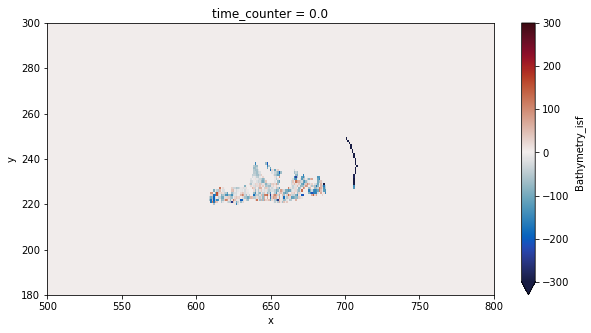

In [19]:
(new_bathy.Bathymetry_isf - ds_bathy.Bathymetry_isf).plot(xlim=(500, 800), ylim=(180, 300), figsize=(10,5), vmin=-300, vmax=300, cmap=cmocean.cm.balance)

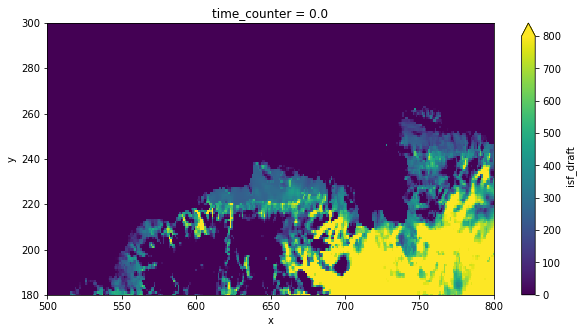

In [14]:
new_bathy.isf_draft.plot(xlim=(500, 800), ylim=(180, 300), figsize=(10,5), vmin=0, vmax=800)

Modify meshmask and domain_cfg files directly:

In [3]:
my_domcfg    = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc')
# my_meshmask  = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20240305.nc')
IGE_domcfg   = xr.open_dataset(f'{base_dir}eANT025-orig/domain_cfg_eANT025.L121.nc')
# IGE_meshmask = xr.open_dataset(f'{base_dir}eANT025-orig/mesh_mask_eANT025.L121.nc')
new_domcfg   = my_domcfg.copy()
# new_meshmask = my_meshmask.copy()

# fin_meshmask  = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305-deep-getz.nc')

In [ ]:
# simple test domain_cfg:
getz_array = np.zeros(my_meshmask.tmask.isel(y=slice(0,439)).values.shape)
getz_array[:,:,200:260,605:689] = 1
getz_region = xr.zeros_like(my_meshmask.tmask.isel(y=slice(0,439)))
getz_region.data = getz_array

for var in [s for s in list(my_domcfg.keys())[10:] if s not in ['e3t_1d','e3w_1d']]: 
    #['isf_draft', 'top_level', 'bottom_level', 'bathy_metry']:
    if len(my_domcfg[var].dims) > 3:
        new_var = xr.where(getz_region==1, IGE_domcfg[var], my_domcfg[var].isel(y=slice(0,439)))
    else:
        new_var = xr.where(getz_region.isel(nav_lev=0)==1, IGE_domcfg[var], my_domcfg[var].isel(y=slice(0,439)))
    new_var = xr.concat([new_var, my_domcfg[var].isel(y=slice(439,None))], dim='y')
    new_domcfg[var] = new_var

new_domcfg.to_netcdf(f'{base_dir}bathymetry/domain_cfg-20240305-deep-getz.nc')

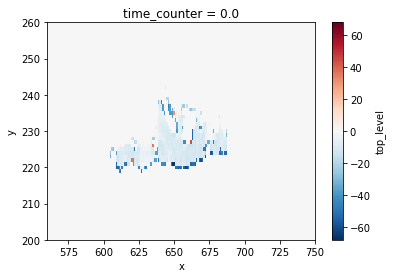

In [5]:
var = 'top_level'
(new_domcfg[var].squeeze() - my_domcfg.squeeze()[var]).plot(xlim=(560,750), ylim=(200,260))

In [9]:
getz_array = np.zeros(my_meshmask.tmask.isel(y=slice(0,439)).values.shape)
getz_array[:,:,200:260,605:689] = 1
getz_region = xr.zeros_like(my_meshmask.tmask.isel(y=slice(0,439)))
getz_region.data = getz_array
for var in list(my_meshmask.keys())[10:]:
    if len(my_meshmask[var].dims) > 3:
        new_var = xr.where(getz_region==1, IGE_meshmask[var], my_meshmask[var].isel(y=slice(0,439)))
        new_var = xr.concat([new_var, my_meshmask[var].isel(y=slice(439,None))], dim='y')
        
        new_meshmask[var] = new_var
new_meshmask.to_netcdf(f'{base_dir}bathymetry/mesh_mask-20240305-deep-getz.nc')

Check fill initial conditions:

In [15]:
new_domcfg = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305-deep-getz.nc')
new_icsT = xr.open_dataset(f'{base_dir}initial-conditions/SOSE-ConsTemp-initial-conditions-20250117.nc')
new_icsS = xr.open_dataset(f'{base_dir}initial-conditions/SOSE-AbsSal-initial-conditions-20250117.nc')

In [17]:
issue = xr.where((new_domcfg.squeeze().bottom_level) < (new_domcfg.squeeze().top_level), 1, 0)

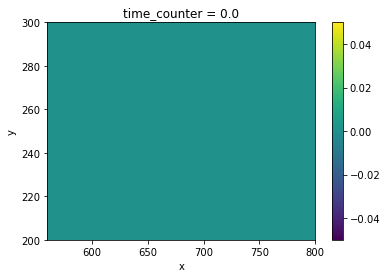

In [18]:
issue.plot(xlim=(560,800), ylim=(200,300))